In [2]:
import numpy as np
import pandas as pd 
import spacy
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
import seaborn as sns
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as stop_words
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer 

import string
import re

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
from sklearn import metrics

from time import time

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sathu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\sathu\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
data = pd.read_csv('US-Economic-News.csv', encoding = 'ISO-8859-1')
display(data.shape) 

(8000, 15)

In [4]:
data["relevance"].value_counts()

no          6571
yes         1420
not sure       9
Name: relevance, dtype: int64

In [5]:
data = data[data.relevance != "not sure"]
data.shape

#gets rid of all 'not sure' values so that we're just left with yes or no

(7991, 15)

In [6]:
data["relevance"].value_counts()/data.shape[0] 

#finds %frequency of each value

no     0.8223
yes    0.1777
Name: relevance, dtype: float64

In [7]:
fig = go.Figure([go.Bar(x=data['relevance'].value_counts().index, y=data['relevance'].value_counts().tolist())])
fig.update_layout(
    title="Values in each Sentiment",
    xaxis_title="Sentiment",
    yaxis_title="Values")
fig.show()

TEXT PREPROCESSING

In [8]:
data['relevance'] = data.relevance.map({'yes':1, 'no':0}) # relevant is 1, not-relevant is 0 
data = data[["text","relevance"]] # taking text input and output variable as relevance
data = data[:1000]
data.shape

(1000, 2)

In [9]:
data.head()

,text,relevance
0,NEW YORK -- Yields on most certificates of dep...,1
1,The Wall Street Journal Online</br></br>The Mo...,0
2,WASHINGTON -- In an effort to achieve banking ...,0
3,The statistics on the enormous costs of employ...,0
4,NEW YORK -- Indecision marked the dollar's ton...,1


In [10]:
data['text'][0]

'NEW YORK -- Yields on most certificates of deposit offered by major banks dropped more than a tenth of a percentage point in the latest week, reflecting the overall decline in short-term interest rates.</br></br>On small-denomination, or "consumer," CDs sold directly by banks, the average yield on six-month deposits fell to 5.49% from 5.62% in the week ended yesterday, according to an 18-bank survey by Banxquote Money Markets, a Wilmington, Del., information service.</br></br>On three-month "consumer" deposits, the average yield sank to 5.29% from 5.42% the week before, according to Banxquote. Two banks in the Banxquote survey, Citibank in New York and CoreStates in Pennsylvania, are paying less than 5% on threemonth small-denomination CDs.</br></br>Declines were somewhat smaller on five-year consumer CDs, which eased to 7.37% from 7.45%, Banxquote said.</br></br>Yields on three-month and six-month Treasury bills sold at Monday\'s auction plummeted more than a fifth of a percentage po

TEXT CLEANING

In [11]:
nlp = spacy.load('en_core_web_sm')

stopwords = stop_words
lemmatizer = WordNetLemmatizer()

def clean(doc):
    text_no_namedentities = []
    document = nlp(doc)
    ents = [e.text for e in document.ents]
    for item in document:
        if item.text in ents:
            pass
        else:
            text_no_namedentities.append(item.text)
    doc = (" ".join(text_no_namedentities))

    doc = doc.lower().strip()
    doc = doc.replace("</br>", " ") 
    doc = doc.replace("-", " ") 
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stopwords])    
    doc = "".join([lemmatizer.lemmatize(word) for word in doc])
    return doc

In [12]:
clean(data['text'][0])

'new york yields certificates deposit offered major banks dropped tenth percentage point latest week reflecting overall decline short term rates br small denomination consumer cds sold directly banks average yield month deposits fell week ended yesterday according bank survey money markets information service br month consumer deposits average yield sank week according banks survey new york paying small denomination declines somewhat smaller year consumer cds eased said br yields month month bills sold s auction plummeted fifth percentage point previous week respectively'

In [13]:
data['text'] = data['text'].apply(clean)
data.head()

,text,relevance
0,new york yields certificates deposit offered m...,1
1,wall street journal online br morning brief lo...,0
2,effort achieve banking reform negotiators admi...,0
3,statistics enormous costs employee drug abuse ...,0
4,new york indecision marked dollar s tone trade...,1


In [14]:
docs = list(data['text'])
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_features = 20000) 
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(docs)
docs = tfidf_vectorizer_vectors.toarray()

In [15]:
data

,text,relevance
0,new york yields certificates deposit offered m...,1
1,wall street journal online br morning brief lo...,0
2,effort achieve banking reform negotiators admi...,0
3,statistics enormous costs employee drug abuse ...,0
4,new york indecision marked dollar s tone trade...,1
...,...,...
996,drug maker hoping reenter lucrative market art...,0
997,electricity deregulation rolled private equity...,0
998,wall street s leading corporate drama s openin...,1
999,new york earlier year rising energy prices cas...,0


In [16]:
X = docs 
y = data['relevance']
print(X.shape, y.shape)

(1000, 12523) (1000,)


In [17]:
go.Figure([go.Bar(x=y.value_counts().index, y=y.value_counts().tolist())])

In [18]:
fig = go.Figure([go.Bar(x=y.value_counts().index, y=y.value_counts().tolist())])
fig.update_layout(
    title="Values in each Sentiment",
    xaxis_title="Sentiment",
    yaxis_title="Values")
fig.show()

In [19]:
SEED=123
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(800, 12523) (800,)
(200, 12523) (200,)


In [20]:
(X_train[777])

array([0., 0., 0., ..., 0., 0., 0.])

Gaussian Naive Bayes

In [21]:
gnb = GaussianNB() 
%time gnb.fit(X_train, y_train)

y_pred_train = gnb.predict(X_train)
y_pred_test = gnb.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

CPU times: total: 0 ns
Wall time: 168 ms

Training Accuracy score: 0.9975
Testing Accuracy score: 0.765


In [22]:
print(classification_report(y_test, y_pred_test, target_names=['not relevant', 'relevant']))

              precision    recall  f1-score   support

not relevant       0.77      0.99      0.86       151
    relevant       0.67      0.08      0.15        49

    accuracy                           0.77       200
   macro avg       0.72      0.53      0.50       200
weighted avg       0.74      0.77      0.69       200



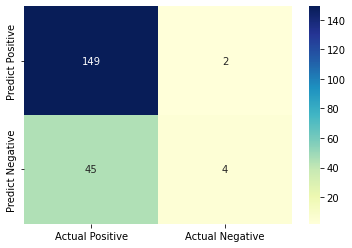

In [23]:
cm = confusion_matrix(y_test, y_pred_test)
# print('Confusion matrix\n', cm)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'], 
                        index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

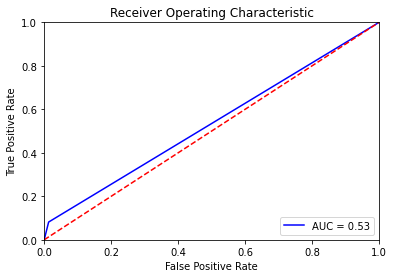

In [24]:
probs = gnb.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Multinomial Naive Bayes

In [25]:
mnb = MultinomialNB() 
%time mnb.fit(X_train, y_train)

y_pred_train = mnb.predict(X_train)
y_pred_test = mnb.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

CPU times: total: 46.9 ms
Wall time: 60.5 ms

Training Accuracy score: 0.7575
Testing Accuracy score: 0.755


In [26]:
print(classification_report(y_test, y_pred_test, target_names=['not relevant', 'relevant']))

              precision    recall  f1-score   support

not relevant       0.76      1.00      0.86       151
    relevant       0.00      0.00      0.00        49

    accuracy                           0.76       200
   macro avg       0.38      0.50      0.43       200
weighted avg       0.57      0.76      0.65       200



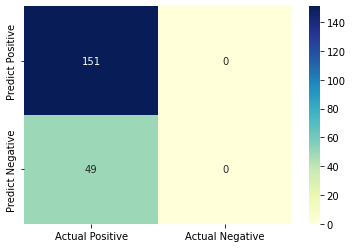

In [27]:
cm = confusion_matrix(y_test, y_pred_test)
# print('Confusion matrix\n', cm)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'], 
                        index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

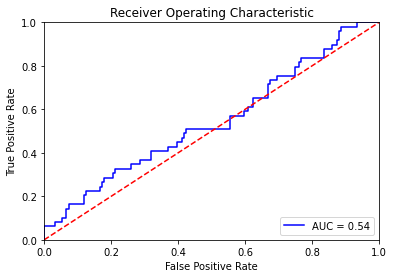

In [28]:
probs = mnb.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

LOGISITIC REGRESSION

In [29]:
lr = LogisticRegression(random_state=SEED)
%time lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

CPU times: total: 172 ms
Wall time: 334 ms

Training Accuracy score: 0.81375
Testing Accuracy score: 0.765


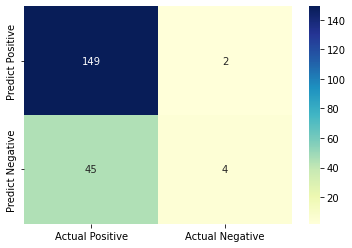

In [30]:
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'], 
                        index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [31]:
print(classification_report(y_test, y_pred_test, target_names=['not relevant', 'relevant']))


              precision    recall  f1-score   support

not relevant       0.77      0.99      0.86       151
    relevant       0.67      0.08      0.15        49

    accuracy                           0.77       200
   macro avg       0.72      0.53      0.50       200
weighted avg       0.74      0.77      0.69       200



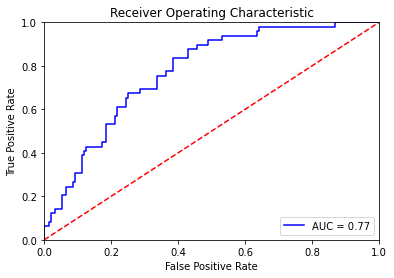

In [32]:
probs = lr.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

SUPPORT VECTOR MACHINES

In [33]:
svc =  LinearSVC(class_weight='balanced') 
%time svc.fit(X_train, y_train)

y_pred_train = svc.predict(X_train)
y_pred_test = svc.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

CPU times: total: 46.9 ms
Wall time: 95.6 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.75


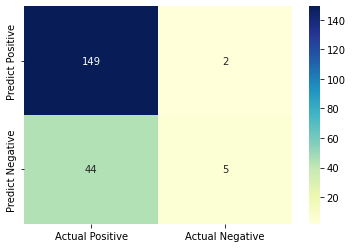

In [40]:
cm = confusion_matrix(y_test, y_pred_test)
# print('Confusion matrix\n', cm)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'], 
                        index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [41]:
print(classification_report(y_test, y_pred_test, target_names=['not relevant', 'relevant']))


              precision    recall  f1-score   support

not relevant       0.77      0.99      0.87       151
    relevant       0.71      0.10      0.18        49

    accuracy                           0.77       200
   macro avg       0.74      0.54      0.52       200
weighted avg       0.76      0.77      0.70       200



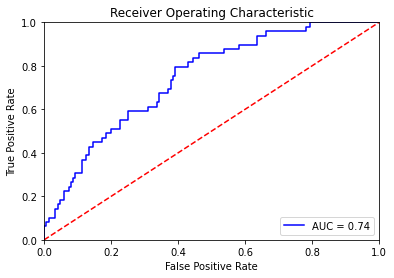

In [42]:
probs = svc._predict_proba_lr(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

DECISION TREE CLASSIFIER

In [43]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=SEED)
%time dt.fit(X_train, y_train)

y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

CPU times: total: 1.22 s
Wall time: 1.28 s

Training Accuracy score: 1.0
Testing Accuracy score: 0.71


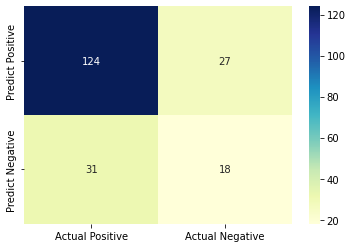

In [44]:
cm = confusion_matrix(y_test, y_pred_test)
# print('Confusion matrix\n', cm)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'], 
                        index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [36]:
print(classification_report(y_test, y_pred_test, target_names=['not relevant', 'relevant']))

              precision    recall  f1-score   support

not relevant       0.80      0.82      0.81       151
    relevant       0.40      0.37      0.38        49

    accuracy                           0.71       200
   macro avg       0.60      0.59      0.60       200
weighted avg       0.70      0.71      0.71       200



ENSEMBLING

In [37]:
from sklearn.ensemble import VotingClassifier

classifiers = [('Decision Tree', dt),
               ('Logistic Regression', lr),
                ('Naive Bayes', gnb)
              ]
vc = VotingClassifier(estimators=classifiers)
# Fit 'vc' to the traing set and predict test set labels
vc.fit(X_train, y_train)
y_pred_train=vc.predict(X_train)
y_pred_test = vc.predict(X_test)
print("Training Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

Training Accuracy score: 1.0
Testing Accuracy score: 0.77


In [39]:
predictions = pd.Series(vc.predict(X), name="relevant")
results = pd.concat([predictions],axis=1)
results.to_csv("us-economic-news-relevance.csv",index=False)